VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Trying to train a GP-VAE...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import sys
import os

# Add the parent directory to sys.path to find the libs module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# print(f"Added {parent_dir} to Python path")
# print(f"Current working directory: {os.getcwd()}")
# print(f"Python path: {sys.path}")

In [3]:
from libs.gpvae_lib import seed_everything
from libs.gpvae_lib import Encoder, GaussianDecoder, GaussianProcessPriorMaison, EncoderMean, EncoderCovariance
from libs.gpvae_lib import DecoderMean, make_mlp, GPNullMean, GPConstantMean, compute_vlb, kl_maison
from libs.gpvae_lib import CauchyKernel, RQKernel, MaternKernel # GaussianKernel, 
from libs.gpvae_lib import compute_vlb

In [4]:
# Set seed for reproducibility
seed_everything(42)

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


# Data simplissime

In [6]:
# Dimensions
Dx = 1
Dz = 1

# parameters
N = 200
B = 1

t shape: torch.Size([1, 200])
x shape: torch.Size([1, 200])


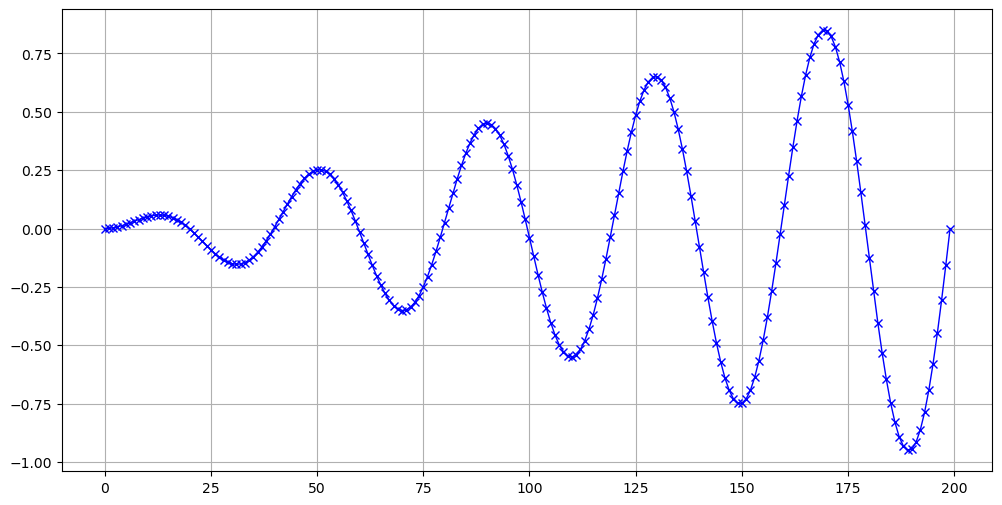

In [7]:
t = torch.linspace(0, 1, N).reshape(1, N).to(device)  # (1, N)
print(f"t shape: {t.shape}")  # (1, N)
x = t * torch.sin(t * 2 * np.pi * 5)
# x = t * torch.sin(t * 2 * np.pi * t)
print(f"x shape: {x.shape}") # (1, N)

fig, ax = plt.subplots(figsize=(12, 6))
# Plot the original time series
ax.plot(x[0, :].detach().cpu().numpy(), label='Original Time Series', color='blue', marker='x', linewidth=1)
ax.grid(True)
plt.show()

# Modèle

Encoder

### NB : l'implémentation de l'encoder covariance dans gpvae_lib (diagonale + triangulaire inférieure) ne semble pas permettre d'apprendre le prior GP

In [8]:
class EncoderPrecision(nn.Module):
    """Reprise de l'implémentation du papier GPVAE avec
    matrice de précision triangulaire supérieure à deux bandes
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 2,
                 inter_dim = 32,
                 activation = nn.ReLU,
                 epsilon = 1e-3
                 ):
        
        super(EncoderPrecision, self).__init__()
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
        self.epsilon = float(epsilon) 
        
        self.diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
        self.off_diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
    def forward(self, x):
        """
        x : (B, N, Dx)
        return : (B, Dz, Dz)
        """
        N = x.size(-1)
        
        # Compute the diagonal part
        D = self.diagonal_mlp(x) # (B, N, Dz)
        D = torch.transpose(D, -1, -2)  # (B, Dz, N)
        D = torch.exp(D) # ensure > 0
        D = torch.diag_embed(D) # (B, Dz, N, N)
        
        # compute the upper band
        U = self.off_diagonal_mlp(x) # (B, N, Dz)
        U = torch.transpose(U, -1, -2)  # (B, Dz, N)
        U = torch.diag_embed(U[...,:-1], offset=1)  # (B, Dz, N, N)
        
        # Combine diagonal and upper band
        B = D + U # (B, Dz, N, N)

        precision_matrix = torch.transpose(B, -1, -2) @ B  # (B, N, Dz, Dz)        
        # Add epsilon to the diagonal to ensure PSD numerical stability
        precision_matrix = precision_matrix + self.epsilon * torch.eye(N, device=device).reshape(1, 1, N, N)
        
        return D, B, precision_matrix  # (B, Dz, N, N)
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(x_dimension={self.x_dimension}, "
                f"z_dimension={self.z_dimension}, n_layers={self.n_layers}, "
                f"inter_dim={self.inter_dim}, activation={self.activation.__name__}, "
                f"epsilon={self.epsilon})")

Choix 1 pour obtenir la matrice de covariance de $q_{\phi}$ : assembler une matrice de précision en passant par une bi-bande traingulaire supérieure

In [9]:
encoder_precision = EncoderPrecision(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

a = torch.randn(1, 10, 1).to(device)  # (B, N, Dx)
D, B, precision_matrix = encoder_precision(a)
print(f"batch size = {a.size(0)}")
print(f"longueur de la séquence = {a.size(1)}")
print(f"Dimension de l'entrée x = {a.size(-1)}")

print(f"Batch matrices diagonales D, shape: {D.shape}")  # (B, Dz, N, N)
print(f"Batch matrices bi-bandes B, shape: {B.shape}")  # (B, Dz, N, N)
print(f"Batch matrices précision, shape: {precision_matrix.shape}")  # (B, N, Dz, Dz)

batch size = 1
longueur de la séquence = 10
Dimension de l'entrée x = 1
Batch matrices diagonales D, shape: torch.Size([1, 1, 10, 10])
Batch matrices bi-bandes B, shape: torch.Size([1, 1, 10, 10])
Batch matrices précision, shape: torch.Size([1, 1, 10, 10])


Choix 2 : assembler une matrice triangulaire inférieure L, et calculer L @ L.T (Cholesky)

In [10]:
encoder_covariance = EncoderCovariance(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

a = torch.randn(1, 10, 1).to(device)  # (B, N, Dx)
L, covariance_matrix = encoder_covariance(a)
print(f"batch size = {a.size(0)}")
print(f"longueur de la séquence = {a.size(1)}")
print(f"Dimension de l'entrée x = {a.size(-1)}")

print(f"Batch matrices triangulaires inférieures L, shape: {L.shape}")  # (B, Dz, N, N)
print(f"Batch matrices covariance, shape: {covariance_matrix.shape}")  # (B, N, Dz, Dz)

batch size = 1
longueur de la séquence = 10
Dimension de l'entrée x = 1
Batch matrices triangulaires inférieures L, shape: torch.Size([1, 1, 10, 10])
Batch matrices covariance, shape: torch.Size([1, 1, 10, 10])


In [11]:
encoder_mean = EncoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

In [12]:
# encoder = Encoder(
#     x_dimension=Dx,
#     z_dimension=Dz,
#     n_layers=2,
#     inter_dim=16,
#     activation=nn.ReLU,
#     epsilon=1e-12
# ).to(device)

# print(encoder)

Decoder

In [13]:
decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

decoder_logvar = make_mlp(
    input_dim=N,
    output_dim=N,
    n_layers=2,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(decoder_logvar)

DecoderMean x_dimension=1, z_dimension=1, n_layers=2, inter_dim=16, activation=ReLU
Sequential(
  (0): Linear(in_features=200, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=200, bias=True)
)


Prior Gaussian Process

In [14]:
# Copied from libs/gpvae_lib pour debugger - Gaussian Kernel with learnable parameters

class GaussianKernel(nn.Module):  
    """Gaussian kernel for one univariate Gaussian Process.
    The lengthscale and variance parameters are learnable (nn.Parameter).
    """
    
    # we need to add a small positive constant to ensure positive definiteness of the kernel matrix
    # 1e-3 is ok for time series up to 10,000 time points.
    # 1e-4 is ok for time series up to 2,880 time points. (ie 2 days @ 1 minute resolution).
    # 1e-4 is ok for time series up to 1,000 time points.
    # 1e-6 is ok for time series up to 100 time points.
    # the value can be decreased for shorter time series.
    # but it should not be too small, otherwise the Cholesky decomposition will fail.
    
    def __init__(self, lengthscale=1.0, sigma=1.0, epsilon=1e-3):
        super(GaussianKernel, self).__init__()
        
        # learnable parameters for the Gaussian kernel
        self.lengthscale = nn.Parameter(torch.tensor(lengthscale))  # learnable lengthscale parameter       
        self.sigma = nn.Parameter(torch.tensor(sigma))  # learnable variance parameter
        
        self.epsilon = torch.tensor(epsilon)  # tolerance to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Gaussian kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "GaussianKernel object : Input tensors must have the same number of dimensions"
        
        # Compute the Gaussian kernel matrix
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (N, M)
        else:
            t1_b = t1.unsqueeze(-1) # (...,N, 1)
            t2_b = t2.unsqueeze(-2) # (...,1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (..., N, M)
        
        gaussian_kernel_matrix = self.sigma**2 * kernel  # (..., N, M)

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            gaussian_kernel_matrix = gaussian_kernel_matrix + self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)

            try:
                L = torch.linalg.cholesky(gaussian_kernel_matrix)  # Cholesky decomposition to ensure positive definiteness
                return gaussian_kernel_matrix, L  # Return the kernel matrix and its Cholesky factor L
            
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed. Tolerance alpha is likely too low.") 
            
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return gaussian_kernel_matrix, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(lengthscale={self.lengthscale.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"epsilon={self.epsilon.item():.3e})")      

In [15]:
class FixedGaussianKernel(nn.Module):  
    """Gaussian kernel for one univariate Gaussian Process.
    The lengthscale and variance parameters are NOT learnable here.
    """
    
    # we need to add a small positive constant to ensure positive definiteness of the kernel matrix
    # 1e-3 is ok for time series up to 10,000 time points.
    # 1e-4 is ok for time series up to 2,880 time points. (ie 2 days @ 1 minute resolution).
    # 1e-4 is ok for time series up to 1,000 time points.
    # 1e-6 is ok for time series up to 100 time points.
    # the value can be decreased for shorter time series.
    # but it should not be too small, otherwise the Cholesky decomposition will fail.
    
    def __init__(self, lengthscale=1.0, sigma=1.0, epsilon=1e-3):
        super(FixedGaussianKernel, self).__init__()
        
        # learnable parameters for the Gaussian kernel
        self.lengthscale = torch.tensor(lengthscale)  # lengthscale parameter       
        self.sigma = torch.tensor(sigma)  # sigma parameter (variance = sigma**2)
        
        self.epsilon = torch.tensor(epsilon)  # tolerance to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Gaussian kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "GaussianKernel object : Input tensors must have the same number of dimensions"
        
        # compute the Gaussian kernel matrix
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (N, M)
        else:
            t1_b = t1.unsqueeze(-1) # (...,N, 1)
            t2_b = t2.unsqueeze(-2) # (...,1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (..., N, M)
            
        gaussian_kernel_matrix = self.sigma**2 * kernel  # (..., N, M)

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            gaussian_kernel_matrix += self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)
            try:
                L = torch.linalg.cholesky(gaussian_kernel_matrix)  # Cholesky decomposition to ensure positive definiteness
                return gaussian_kernel_matrix, L  # Return the kernel matrix and its Cholesky factor L
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed. Tolerance alpha is likely too low.") 
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return gaussian_kernel_matrix, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(lengthscale={self.lengthscale.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"epsilon={self.epsilon.item():.3e})")      

In [16]:
class FixedRQKernel(nn.Module):
    """Rational Quadratic kernel for one univariate Gaussian Process.
    The lengthscale, variance and alpha parameters are NOT learnable.
    """
    
    def __init__(self, alpha=1.0, beta=1.0, sigma=1.0, epsilon=1e-3):
        super(FixedRQKernel, self).__init__()
        
        # learnable parameters for the RQ kernel
        self.alpha = torch.tensor(alpha)  # alpha parameter (shape parameter)
        self.beta = torch.tensor(beta)  # beta parameter       
        self.sigma = torch.tensor(sigma)  # variance = sigma**2 parameter

        self.epsilon = epsilon  # small value to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Rational Quadratic kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "RQKernel object : Input tensors must have the same number of dimensions"
        
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
            mat = 1 + ((t1_b - t2_b)**2 / (2 * self.alpha / self.beta)) # (N, M)
        else:
            t1_b = t1.unsqueeze(-1) # (..., N, 1)
            t2_b = t2.unsqueeze(-2) # (..., 1, M)
            mat = 1 + ((t1_b - t2_b)**2 / (2 * self.alpha / self.beta))  # (N, M)
            
        rq_kernel_matrix = self.sigma**2 * mat**(-self.alpha)  # (..., N, M)

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            rq_kernel_matrix += self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)
            try:
                L = torch.linalg.cholesky(rq_kernel_matrix)  # Cholesky decomposition to ensure positive definiteness
                return rq_kernel_matrix, L  # Return the kernel matrix and its Cholesky factor L
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed in RQKernel. Tolerance epsilon is likely too low.") 
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return rq_kernel_matrix, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(alpha={self.alpha.item():.3e}, "
                f"beta={self.beta.item():.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"epsilon={self.epsilon:.3e})")     

In [17]:
prior_mean = GPConstantMean(
    constant_init = 0.0
)

# prior_mean = GPNullMean()
print(prior_mean)

GPConstantMean, constant_value=0.000e+00)


In [18]:
# Gaussian kernel prior
prior_kernel = GaussianKernel(
    lengthscale=0.1,
    sigma=1.0,
    epsilon=1e-12
)
print(prior_kernel)

# # Cauchy kernel prior
# prior_kernel = CauchyKernel(
#     lengthscale=0.1,
#     sigma=1.0,
#     epsilon=1e-12
# )

# print(prior_kernel)

GaussianKernel(lengthscale=1.000e-01, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-12)


# Training

Encode Time Series

In [19]:
x_ext = x.unsqueeze(-1)  # (B, N, Dx)
print(f"x shape: {x.shape}")  # (1, N)
print(f"x_ext shape: {x_ext.shape}")  # (1, N, 1)

x shape: torch.Size([1, 200])
x_ext shape: torch.Size([1, 200, 1])


Encoder

$q_\phi (z_{1:N} \vert x_{1:N})$ est une Gaussienne multivariée de dimension $N$ égale à la longueur de la time série.

In [20]:
# vecteur moyenne de q_phi
mu_phi = encoder_mean(x_ext)  # (B, Dz, N)
mu_phi = mu_phi.squeeze(0)  # (Dz, N)

# on a deux possibilités pour obtenir la matrice de covariance de q_phi

#------- CHOIX 1 : PRECISION MATRIX -------
# # 1- calculer la matrice de précision en passant par une matrice bi-bandes traingulaire supérieure
# # (encoder_precision)
# _, _, precision_phi = encoder_precision(x_ext)  # (B, Dz, N, N)
# precision_phi = precision_phi.squeeze(0)  # (Dz, N, N)

# q_phi = torch.distributions.MultivariateNormal(
#     loc=mu_phi,  # (Dz, N)
#     precision_matrix=precision_phi,  # (Dz, N, N)
# )


# ------- CHOIX 2 : COVARIANCE MATRIX -------
# ou calculer une matrice de covariance en assemblant une triangulaire inférieure L
# et en calculant L @ L.T (Cholesky decomposition)
L_phi, covariance_phi = encoder_covariance(x_ext)  # (B, Dz, N, N)
covariance_phi = covariance_phi.squeeze(0)  # (Dz, N, N)
L_phi = L_phi.squeeze(0)  # (Dz, N, N)

q_phi = torch.distributions.MultivariateNormal(
    loc=mu_phi,  # (Dz, N)
    scale_tril=L_phi,  # (Dz, N, N)
)


# ----- Summary de l'encoder q_phi -----
print(f"mu_phi shape: {mu_phi.shape}")
print(f"sigma_phi shape: {q_phi.covariance_matrix.shape}")
print(f"q_phi: {q_phi}")
print(f"\tq_phi batch shape: {q_phi.batch_shape}")
print(f"\tq_phi event shape: {q_phi.event_shape}")

mu_phi shape: torch.Size([1, 200])
sigma_phi shape: torch.Size([1, 200, 200])
q_phi: MultivariateNormal(loc: torch.Size([1, 200]), covariance_matrix: torch.Size([1, 200, 200]), scale_tril: torch.Size([1, 200, 200]))
	q_phi batch shape: torch.Size([1])
	q_phi event shape: torch.Size([200])


In [21]:
# mu_phi, sigma_phi, _ = encoder(x_ext)

# mu_phi = mu_phi.squeeze(0)  # (B, N, Dz)
# sigma_phi = sigma_phi.squeeze(0)  # (B, N, Dz)

# q_phi = torch.distributions.MultivariateNormal(
#     loc=mu_phi,  # (B, N, Dz)
#     covariance_matrix=sigma_phi,  # (B, N, Dz, Dz)
# )

# print(f"mu_phi shape: {mu_phi.shape}")
# print(f"sigma_phi shape: {sigma_phi.shape}")
# print(f"q_phi: {q_phi}")
# print(f"\tq_phi batch shape: {q_phi.batch_shape}")
# print(f"\tq_phi event shape: {q_phi.event_shape}")

Sample K latent variables

In [22]:
# number of latent variables to sample from q_phi

K = 100

In [23]:
z_sampled = q_phi.rsample((K,))  # (K, B, N)
print(f"z_sampled shape: {z_sampled.shape}")
z_sampled_ext = z_sampled.unsqueeze(-1)  # (K, B, N, Dz)
print(f"z_sampled_ext shape: {z_sampled_ext.shape}")

z_sampled shape: torch.Size([100, 1, 200])
z_sampled_ext shape: torch.Size([100, 1, 200, 1])


Each sampled z is used to instantiate independent -and not identical !- $p_{\theta_x}$

In [24]:
mu_x = decoder_mean(z_sampled_ext)  # (K, B, N, Dx)
mu_x = mu_x.squeeze(-1)  # (K, B, N)
print(f"mu_x shape: {mu_x.shape}")

logvar_x = decoder_logvar(z_sampled)  # (K, B, N)
print(f"logvar_x shape: {logvar_x.shape}")
covar_x = torch.diag_embed(logvar_x.exp())  # (K, B, N, N)
print(f"covar_x shape: {covar_x.shape} - NB : covar_x est diagonale, les x_t sont indépendants")

p_theta_x = torch.distributions.MultivariateNormal(
    loc=mu_x,
    covariance_matrix=covar_x
)
print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}") # (K, B)
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}") # (N,)

mu_x shape: torch.Size([100, 1, 200])
logvar_x shape: torch.Size([100, 1, 200])
covar_x shape: torch.Size([100, 1, 200, 200]) - NB : covar_x est diagonale, les x_t sont indépendants
p_theta_x: MultivariateNormal(loc: torch.Size([100, 1, 200]), covariance_matrix: torch.Size([100, 1, 200, 200]))
	p_theta_x batch shape: torch.Size([100, 1])
	p_theta_x event shape: torch.Size([200])


In [25]:
# K = 10 # number of samples to draw from the decoder distribution
# x_sampled = p_theta_x.rsample((K,))  # (K, B, L, Dx)
# print(f"x_samples shape ({K} samples): {x_sampled.shape}")

Compute the Gaussian Process prior at times t's. $p_{\theta_z}$ is a Gaussian Process, ie a multivariate Gaussian for times t's.

In [26]:
mu_z = prior_mean(t)  # (1, N, Dz)
sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

p_theta_z = torch.distributions.MultivariateNormal(
    loc=mu_z,  # (N, Dz)
    scale_tril=L_z  # (N, N)
)

print(f"mu_z shape: {mu_z.shape}")
print(f"sigma_z shape: {sigma_z.shape}")
print(f"p_theta_z: {p_theta_z}")
print(f"\tp_theta_z batch shape: {p_theta_z.batch_shape}")
print(f"\tp_theta_z event shape: {p_theta_z.event_shape}")

mu_z shape: torch.Size([1, 200])
sigma_z shape: torch.Size([1, 200, 200])
p_theta_z: MultivariateNormal(loc: torch.Size([1, 200]), scale_tril: torch.Size([1, 200, 200]))
	p_theta_z batch shape: torch.Size([1])
	p_theta_z event shape: torch.Size([200])


Compute the metrics and the loss

In [27]:
kl = torch.distributions.kl_divergence(q_phi, p_theta_z)  # (B, N)
print(f"kl shape: {kl.shape}")

# compute the reconstruction loss of x with each of the K sampled p_theta_x
reco_loss = -p_theta_x.log_prob(x)  # (K, 1)
print(f"reco_loss shape: {reco_loss.shape}")

loss = - reco_loss.mean() + kl.mean()  # (B, N)
# print(f"loss shape: {loss.shape}")
print(f"loss: {loss.item():.4e}")

kl shape: torch.Size([1])
reco_loss shape: torch.Size([100, 1])
loss: 9.8394e+13


In [28]:
# Alternative home-made way to compute the VLB

kl_divergence_torch, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
    q_phi, p_theta_x, p_theta_z, x
)

loss = -vlb_value
print(f"Loss : {loss.item():.4e}")

Loss : 9.8394e+13


# Full Training Loop

## Très grande sensibilité au lengthscale !!

Résultats :
- N = 30, l = 0.1, 1000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 100, l = 0.1, 1000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 150, l = 0.1, 1000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation ReLU sur EncoderMean, activation Tanh sur EncoderPrecision : nok !
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation ReLU sur EncoderPrecison, activation Tanh sur EncoderMean : instable, marche au 3e run, peu reproductible.
- N = 200, l = entre 0.1 et 0.14, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok ! NE MARCHE PAS EN DEHORS DE CET INTERVALLE DE LENGTHSCALE
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256 avec Encoder Ben (lower triangular pour covariance Decoder), activation Tanh : ok ! Semble moins bon malgré tout qu'avec le bi-bande. Ne marche qu'avec l <= 0.12
- pas trouvé de set up qui marche avec RQ Kernel

Toujours avec N=200, l=0.10, 5000 epochs, GK, lr=1e-3, activation Tanh - on change le réseau Encoder Mean et Encoder Precision:
- 4 layers x 256 : ok
- 2 x 64 : nok
- 4 x 64 : nok
- 4 x 128 : nok
- EncoderPrecision 4x256, EncoderMean 2x32 : ok, mais moins bon qu'avec 4x256 et 4x256
- Precision 4x256, Mean 4x32 : nok !
- Precison 4x256, Mean 4x64 : nok !
- Precision 4x256, Mean 4x128 : nok !
- Precision 4x512, Mean 4x512 : ok, semble clipper vers les +/-1 (effet Tanh ?)

Toujours avec N=200, l=0.10, GK, lr=1e-3, activation Tanh, (4x256)x2 :
- 100 epochs : nok
- 1000 epochs : ça commence !
- 2000 epochs : idem 1000
- 3000 epochs : mieux...
- 4000 epochs : très bien, tb reconstruction - loss finale : 2.126e+7 (kl 2.1262e+7, reco -4.31e+2)
- 10000 epochs : moins bien ! - loss finale = 8.83e+5, kl = 8.83e+5, reco = -1.15e+2 : reconstruction instable, moins bonne à l'arrêt aux 10000 epochs.
- 100000 epochs : instabilités. Pas de reconstruction. - loss finale = 2.46e+2, kl = 3.04e+2, reco = -5.85e+1.

Changement de fonction : t sin (2 t²) par exemple => fail. Pb quand le lengthscale change.

Très grande sensibilité à l'initialisation. Résultats peu reproductibles. 

Gros bruit dans la reconstruction_loss. Essais avec K samples de $p_{\theta_x}$ : un peu moins de bruit, mais pas de meilleurs résultats. L'erreur de reconstruction semble attaindre un plancher. NB : prendre un PETIT décodeur (ie qui ne va pas underfitter ! par exemple 4 layers x 16 pour N = 200 points)

# Gros BreakThrough : PETIT décodeur, évite l'underfitting

MEILLEURS RESULTATS : N=200, FixedGaussianKernel l=0.1, lr=1e-3, EncoderMean (4x256,nn.Tanh), EncoderPrecision(4x256,nn.Tanh), DecoderMean (4x16,nn.ReLU), Decoder_logvar (4x16,nn.Tanh), 500 epochs, K=100,10 ou même 5 samples de $p_{\theta_x}$

LEARNABLE GAUSSIAN KERNEL : marche très bien ! Apprend -dans une certaine mesure- le bon lengthscale (si l de départ pas trop éloigné de la valeur optimale). Avec décoder light (4x16,mean=nn.ReLU, covar=nn.Tanh)

Assemblage des matrices de covariance : la bi-bande traingulaire supérieure et Cholesky-based marchent bien.

Tous les Kernels fonctionnent !

In [42]:
# encoder = Encoder(
#     x_dimension=Dx,
#     z_dimension=Dz,
#     n_layers=4,
#     inter_dim=256,
#     activation=nn.Tanh,
#     epsilon=1e-12,
# ).to(device)

# print(encoder)
# print()

encoder_mean = EncoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh,
).to(device)

print(encoder_mean)

encoder_precision = EncoderPrecision(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh, 
    epsilon=1e-12
).to(device)

print(encoder_precision)

encoder_covariance = EncoderCovariance(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh,
    epsilon=1e-12
).to(device)

print(encoder_covariance)

decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

decoder_logvar = make_mlp(
    input_dim=N,
    output_dim=N,
    n_layers=4,
    inter_dim=16,
    activation=nn.Tanh,
).to(device)

print(f"Decoder log variance MLP: {decoder_logvar}")
# print(decoder_logvar)

print()

# --- Prior mean ---------------------------------
# prior_mean = GPNullMean()


prior_mean = GPConstantMean(
    constant_init=1.0
)
print(prior_mean)


# --- choose your kernel carefully -----------------------------

prior_kernel = GaussianKernel(
    lengthscale=0.065,
    sigma=0.5,
    epsilon=1e-3
)

print(prior_kernel)

# prior_kernel = FixedRQKernel(
#     epsilon=1e-12,  # small value to ensure positive definiteness of the kernel matrix
#     alpha=0.5,
#     beta=10.0,
#     sigma=1.0,
# )
# print(prior_kernel)

# prior_kernel = CauchyKernel(
#     lengthscale=0.1,
#     sigma=1.0,
#     epsilon=1e-12
# )
# print(prior_kernel)

# prior_kernel = RQKernel(
#     alpha = 1.0,
#     beta = 1.0e+2,
#     sigma = 1.0,
#     epsilon = 1e-12
# )
# print(prior_kernel)

# prior_kernel = MaternKernel(
#     nu=2.5,
#     lengthscale=0.1,
#     sigma=1.0,
#     epsilon=1e-12
# )
# print(prior_kernel)

x_ext = x.unsqueeze(-1)  # (B, N, Dx)
print(f"x_ext shape: {x_ext.shape}")  # (1, N, 1)

EncoderMean, x_dimension=1, z_dimension=1, n_layers=4, inter_dim=256, activation=Tanh
EncoderPrecision(x_dimension=1, z_dimension=1, n_layers=4, inter_dim=256, activation=Tanh, epsilon=1e-12)
EncoderCovariance : (x_dimension=1, z_dimension=1, n_layers=4, inter_dim=256, activation=Tanh, epsilon (to ensure PSD)=1.000e-12)
DecoderMean x_dimension=1, z_dimension=1, n_layers=4, inter_dim=16, activation=ReLU
Decoder log variance MLP: Sequential(
  (0): Linear(in_features=200, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=200, bias=True)
)

GPConstantMean, constant_value=1.000e+00)
GaussianKernel(lengthscale=6.500e-02, variance (sigma**2)=2.500e-01, sigma=5.000e-01, epsilon=1.000e-03)
x_ext shape: torch.Size([1, 200, 1])


In [43]:
N_EPOCHS = int(5e+2)

K = 10

# NB : list(prior_kernel.parameters()) is empty since FixedGaussianKernel has no learnable parameters
# optimizer = torch.optim.Adam(
#     list(encoder.parameters()) + list(decoder_mean.parameters()) + list(decoder_logvar.parameters()) +
#     list(prior_mean.parameters()) + list(prior_kernel.parameters()),
#     lr = 1e-3
# )

optimizer = torch.optim.Adam(
    list(encoder_mean.parameters()) + list(encoder_precision.parameters()) + 
    list(encoder_covariance.parameters()) + list(decoder_mean.parameters()) + 
    list(decoder_logvar.parameters()) +
    list(prior_mean.parameters()) + list(prior_kernel.parameters()),
    lr = 1e-3
)

In [44]:
losses = []
kls = []
reconstruction_losses = []

# dictionnary to store the parameters
mean_params = {}  # to store mean parameters if any
for name, param in prior_mean.named_parameters():
    mean_params[name] = []
    
kernel_params = {}  # to store kernel parameters if any
for name, param in prior_kernel.named_parameters():
    kernel_params[name] = []

In [45]:
if len(list(prior_kernel.parameters())) == 0:
    learnable_kernel = False
    print("Prior kernel is fixed (no learnable parameters).")
else:
    learnable_kernel = True
    print("Prior kernel is learnable (has learnable parameters).")
    
# prior
mu_z = prior_mean(t)  # (1, N, Dz)
sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

p_theta_z = torch.distributions.MultivariateNormal(
        loc=mu_z,  # (N, Dz)
        scale_tril=L_z  # (N, N)
    )

N = t.size(-1)  # number of time points
epsilon = 1e-12
tolerance = epsilon * torch.eye(N).to(device)

for epoch in range(N_EPOCHS):
       
    # if the kernel is learnable, we need to recompute the prior mean and kernel at each epoch
    if learnable_kernel:
        mu_z = prior_mean(t)  # (1, N, Dz)
        sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

        p_theta_z = torch.distributions.MultivariateNormal(
                loc=mu_z,  # (N, Dz)
                scale_tril=L_z  # (N, N)
            )

    # ENCODER
    # encode mean
    mu_phi = encoder_mean(x_ext)  # (B, Dz, N)
    mu_phi = mu_phi.squeeze(0)  # (N, Dz)
    
    # # choice 1 : with precision matrix
    # _, _, precision_phi = encoder_precision(x_ext)  # (B, Dz, N, N)
    # precision_phi = precision_phi.squeeze(0)  # (N, Dz, Dz)

    # q_phi = torch.distributions.MultivariateNormal(
    #     loc=mu_phi,  # (B, N, Dz)
    #     precision_matrix=precision_phi,  # (B, N, Dz, Dz)
    # )
    
    # choice 2 : with covariance matrix
    L_phi, covariance_phi = encoder_covariance(x_ext)  # (B, Dz, N, N)
    covariance_phi = covariance_phi.squeeze(0)  # (Dz, N, N)
    L_phi = L_phi.squeeze(0)  # (Dz, N, N)

    q_phi = torch.distributions.MultivariateNormal(
        loc=mu_phi,  # (Dz, N)
        scale_tril=L_phi,  # (Dz, N, N)
)
    # mu_phi, sigma_phi, _ = encoder(x.unsqueeze(-1))

    # mu_phi = mu_phi.squeeze(0)  # (B, N, Dz)
    # sigma_phi = sigma_phi.squeeze(0)  # (B, N, Dz)

    # q_phi = torch.distributions.MultivariateNormal(
    #     loc=mu_phi,  # (B, N, Dz)
    #     covariance_matrix=sigma_phi,  # (B, N, Dz, Dz)
    # )
    
    # sample z
    z_sampled = q_phi.rsample((K,)) # (K, B, N) as Dz=1
    
    # decode
    mu_x = decoder_mean(z_sampled.unsqueeze(-1))  # (K, B, N, Dx)
    mu_x = mu_x.squeeze(-1)  # (K, B, N)

    logvar_x = decoder_logvar(z_sampled)  # (K, B, N)
    covar_x = torch.diag_embed(logvar_x.exp()) # + tolerance # (K, B, N, N)

    p_theta_x = torch.distributions.MultivariateNormal(
        loc=mu_x,
        covariance_matrix=covar_x
    ) # batch_shape=(K, B), event_shape=(N,)
       
    # compute loss
    kl = torch.distributions.kl_divergence(q_phi, p_theta_z).sum(-1).mean()  # (B, N) => scalar
    reconstruction_loss = p_theta_x.log_prob(x).sum(-1).mean() # (K, B, N) => scalar
    loss = -reconstruction_loss + kl  # (B, N)

    # kl, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
    #     q_phi, p_theta_x, p_theta_z, x
    # )    
        
    # optimization step
    optimizer.zero_grad()
    loss.backward()  
    optimizer.step()
    
    # log losses
    losses.append(loss.item())
    kls.append(kl.mean().item())
    reconstruction_losses.append(-reconstruction_loss.mean().item())
    
    # record parameters
    for name, param in prior_mean.named_parameters():
        mean_params[name].append(param.item())
    for name, param in prior_kernel.named_parameters():
        kernel_params[name].append(param.item())
        
    # print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{N_EPOCHS}], Loss: {loss.item():.4e}, "
              f"KL: {kl.mean().item():.4e}, "
              f"Reconstruction Loss (avg over {K} sample(s)): {-reconstruction_loss.mean().item():.4e}")

Prior kernel is learnable (has learnable parameters).
Epoch [1/500], Loss: 1.0266e+05, KL: 1.0246e+05, Reconstruction Loss (avg over 10 sample(s)): 1.9994e+02
Epoch [10/500], Loss: 2.3718e+03, KL: 2.1751e+03, Reconstruction Loss (avg over 10 sample(s)): 1.9674e+02
Epoch [20/500], Loss: 8.8191e+02, KL: 6.9280e+02, Reconstruction Loss (avg over 10 sample(s)): 1.8912e+02
Epoch [30/500], Loss: 3.8981e+02, KL: 2.1099e+02, Reconstruction Loss (avg over 10 sample(s)): 1.7882e+02
Epoch [40/500], Loss: 3.0133e+02, KL: 1.3618e+02, Reconstruction Loss (avg over 10 sample(s)): 1.6515e+02
Epoch [50/500], Loss: 2.2664e+02, KL: 7.7080e+01, Reconstruction Loss (avg over 10 sample(s)): 1.4956e+02
Epoch [60/500], Loss: 1.8841e+02, KL: 5.4840e+01, Reconstruction Loss (avg over 10 sample(s)): 1.3357e+02
Epoch [70/500], Loss: 1.7394e+02, KL: 5.6317e+01, Reconstruction Loss (avg over 10 sample(s)): 1.1763e+02
Epoch [80/500], Loss: 1.5677e+02, KL: 5.4184e+01, Reconstruction Loss (avg over 10 sample(s)): 1.02

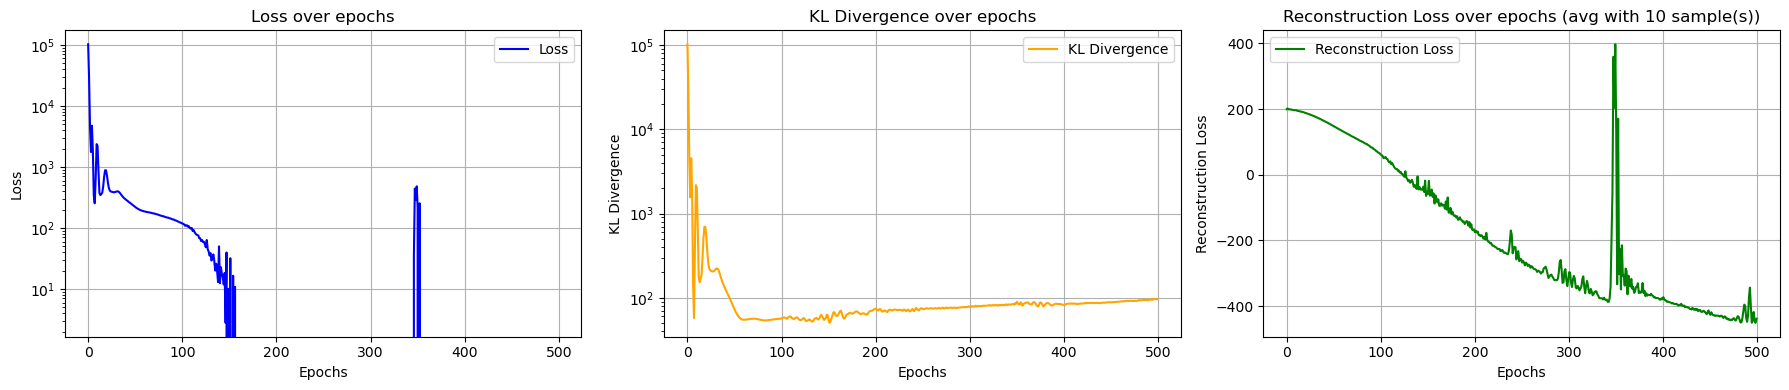

In [46]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))

ax[0].plot(losses, label='Loss', color='blue')
ax[0].set_title('Loss over epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(kls, label='KL Divergence', color='orange')
ax[1].set_title('KL Divergence over epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('KL Divergence')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].legend()

ax[2].plot(reconstruction_losses, label='Reconstruction Loss', color='green')
ax[2].set_title(f'Reconstruction Loss over epochs (avg with {K} sample(s))')
ax[2].set_xlabel('Epochs')      
ax[2].set_ylabel('Reconstruction Loss')
ax[2].grid(True)
ax[2].legend()

plt.tight_layout()
plt.show()

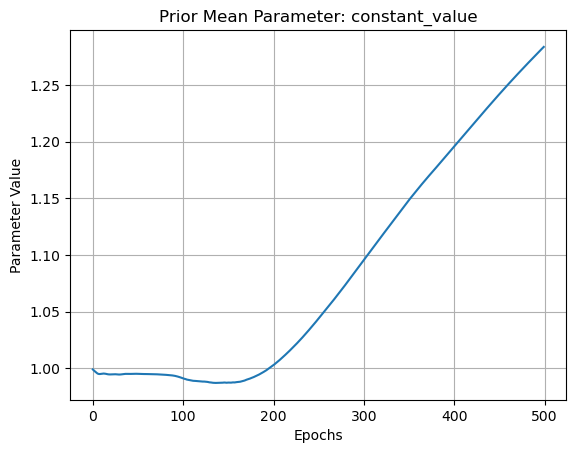

In [47]:
for name, values in prior_mean.named_parameters():
    plt.plot(mean_params[name], label=name)
    plt.title(f'Prior Mean Parameter: {name}')
# plt.title('Prior Mean Parameters over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Parameter Value')
plt.grid(True)
plt.show()

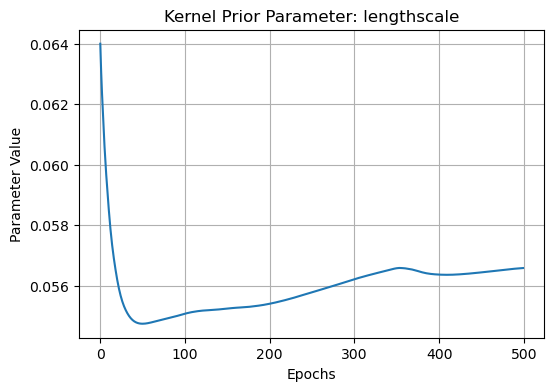

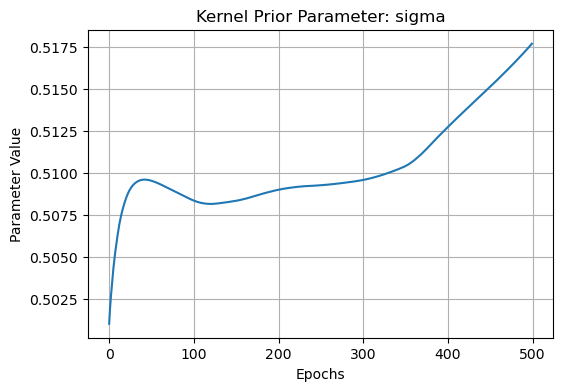

In [48]:
for name, values in prior_kernel.named_parameters():
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(kernel_params[name], label=name)
    ax.set_title(f'Kernel Prior Parameter: {name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Parameter Value')
    ax.grid(True)
    plt.show()

Predictions

In [49]:
z_sampled = q_phi.rsample()  # (B, N)
print(f"z_sampled shape: {z_sampled.shape}")
z_sampled_ext = z_sampled.unsqueeze(-1)  # (B, N, Dz)
print(f"z_sampled_ext shape: {z_sampled_ext.shape}")

z_sampled shape: torch.Size([1, 200])
z_sampled_ext shape: torch.Size([1, 200, 1])


In [50]:
mu_x = decoder_mean(z_sampled_ext)  # (B, N, Dx)
mu_x = mu_x.squeeze(2)  # (B, N)

logvar_x = decoder_logvar(z_sampled)  # (B, N, Dx)
covar_x = torch.diag_embed(logvar_x.exp())  # (B, N, Dx, Dx)

p_theta_x = torch.distributions.MultivariateNormal(
        loc=mu_x,
        covariance_matrix=covar_x
    )

print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")

p_theta_x: MultivariateNormal(loc: torch.Size([1, 200]), covariance_matrix: torch.Size([1, 200, 200]))
	p_theta_x batch shape: torch.Size([1])
	p_theta_x event shape: torch.Size([200])


In [51]:
x_hat = p_theta_x.rsample()  # (K, B, L, Dx)

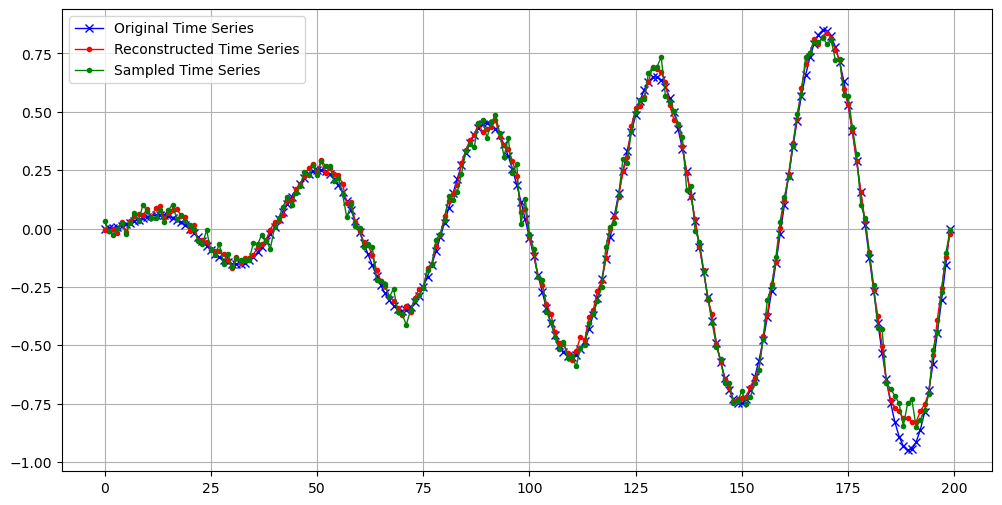

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the original time series

ax.plot(x[0, :].detach().cpu().numpy(), label='Original Time Series', color='blue', marker='x', linewidth=1)
# Plot the reconstructed time series
ax.plot(mu_x[0, :].detach().cpu().numpy(), label='Reconstructed Time Series', color='red', marker='.', linewidth=1)
ax.plot(x_hat[0, :].detach().cpu().numpy(), label='Sampled Time Series', color='green', marker='.', linewidth=1)

ax.grid(True)
ax.legend()
plt.show()

In [53]:
q_phi.covariance_matrix

tensor([[[6.2015e-04, 1.1563e-06, 1.1611e-06,  ..., 6.7681e-07,
          8.7100e-07, 1.1547e-06],
         [1.1563e-06, 6.2015e-04, 1.1649e-06,  ..., 6.7902e-07,
          8.7385e-07, 1.1585e-06],
         [1.1611e-06, 1.1649e-06, 6.2014e-04,  ..., 6.8310e-07,
          8.7910e-07, 1.1654e-06],
         ...,
         [6.7681e-07, 6.7902e-07, 6.8310e-07,  ..., 6.3893e-04,
          8.8827e-07, 1.1776e-06],
         [8.7100e-07, 8.7385e-07, 8.7910e-07,  ..., 8.8827e-07,
          6.2574e-04, 1.5067e-06],
         [1.1547e-06, 1.1585e-06, 1.1654e-06,  ..., 1.1776e-06,
          1.5067e-06, 6.2099e-04]]], device='cuda:0',
       grad_fn=<ExpandBackward0>)

In [54]:
sigma_z

tensor([[[2.6894e-01, 2.6688e-01, 2.6374e-01,  ..., 9.0896e-68,
          1.9143e-68, 4.0000e-69],
         [2.6688e-01, 2.6894e-01, 2.6688e-01,  ..., 4.2820e-67,
          9.0896e-68, 1.9143e-68],
         [2.6374e-01, 2.6688e-01, 2.6894e-01,  ..., 2.0014e-66,
          4.2820e-67, 9.0896e-68],
         ...,
         [9.0896e-68, 4.2820e-67, 2.0014e-66,  ..., 2.6894e-01,
          2.6688e-01, 2.6374e-01],
         [1.9143e-68, 9.0896e-68, 4.2820e-67,  ..., 2.6688e-01,
          2.6894e-01, 2.6688e-01],
         [4.0000e-69, 1.9143e-68, 9.0896e-68,  ..., 2.6374e-01,
          2.6688e-01, 2.6894e-01]]], device='cuda:0', grad_fn=<AddBackward0>)

In [55]:
mu_phi

tensor([[1.3384, 1.3394, 1.3423, 1.3470, 1.3531, 1.3605, 1.3688, 1.3774, 1.3859,
         1.3939, 1.4007, 1.4060, 1.4093, 1.4102, 1.4084, 1.4037, 1.3960, 1.3852,
         1.3716, 1.3552, 1.3365, 1.3159, 1.2939, 1.2712, 1.2485, 1.2265, 1.2059,
         1.1875, 1.1721, 1.1602, 1.1524, 1.1493, 1.1513, 1.1585, 1.1712, 1.1891,
         1.2122, 1.2401, 1.2722, 1.3079, 1.3463, 1.3865, 1.4275, 1.4682, 1.5073,
         1.5438, 1.5764, 1.6042, 1.6262, 1.6415, 1.6496, 1.6499, 1.6421, 1.6262,
         1.6021, 1.5702, 1.5310, 1.4854, 1.4343, 1.3790, 1.3208, 1.2612, 1.2017,
         1.1440, 1.0895, 1.0398, 0.9963, 0.9602, 0.9327, 0.9147, 0.9070, 0.9101,
         0.9241, 0.9491, 0.9847, 1.0303, 1.0851, 1.1479, 1.2174, 1.2920, 1.3699,
         1.4491, 1.5276, 1.6030, 1.6731, 1.7359, 1.7898, 1.8332, 1.8652, 1.8849,
         1.8915, 1.8847, 1.8642, 1.8302, 1.7831, 1.7234, 1.6522, 1.5710, 1.4818,
         1.3871, 1.2894, 1.1914, 1.0955, 1.0041, 0.9197, 0.8442, 0.7797, 0.7278,
         0.6903, 0.6684, 0.6

In [56]:
mu_z

tensor([[1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829, 1.2829,
         1.2829, 1.2829, 1.2

In [57]:
mu_x

tensor([[-7.4504e-03, -1.2121e-02, -2.0895e-03, -1.7842e-02,  2.9671e-02,
         -1.4912e-02,  3.0461e-02,  5.2050e-02,  6.3188e-02,  5.6691e-02,
          8.1940e-02,  4.5302e-02,  8.8945e-02,  9.7414e-02,  4.3802e-02,
          6.4408e-02,  7.9989e-02,  8.5082e-02,  5.4022e-02,  5.0488e-02,
         -1.0110e-02,  1.5502e-02, -4.8406e-02, -5.0458e-02, -5.5767e-02,
         -8.7760e-02, -9.6334e-02, -9.7886e-02, -1.1093e-01, -1.3695e-01,
         -1.6896e-01, -1.2017e-01, -1.4603e-01, -1.2703e-01, -1.2473e-01,
         -1.1207e-01, -8.0284e-02, -6.7028e-02, -4.7974e-02, -4.2772e-03,
          2.8955e-02,  3.2399e-02,  5.6863e-02,  1.2293e-01,  1.2193e-01,
          1.6783e-01,  1.9150e-01,  2.2568e-01,  2.5892e-01,  2.7610e-01,
          2.4046e-01,  2.9292e-01,  2.3661e-01,  2.5896e-01,  2.3392e-01,
          2.2791e-01,  1.9204e-01,  1.0985e-01,  1.1407e-01,  2.8682e-02,
         -9.8340e-03, -5.8075e-02, -7.1482e-02, -1.1407e-01, -1.7699e-01,
         -2.2270e-01, -2.4469e-01, -2.

In [58]:
p_theta_x.covariance_matrix

tensor([[[0.0009, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0008, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0008,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0009, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0009, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0009]]],
       device='cuda:0', grad_fn=<ExpandBackward0>)